In [1]:
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
import sys
from matplotlib import pyplot as plt

In [2]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 2
ALT_MIN, ALT_MAX = 0.5, 64.5  # Updated range
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
CHORDAL_DIST = 2 * np.sin(MAX_DIST_KM / (2 * EARTH_RADIUS_KM))
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

# Optimized chunk sizes
CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000
CHUNK_SIZE_S_PROCESS = 2000
BATCH_SIZE = 10000

In [3]:
def wrap_o3_efficient(da_o3):
    """Efficient wrapping with optimized chunking"""
    da_transposed = da_o3.transpose('time', 'altitude')
    n_time = da_transposed.sizes['time']
    n_alt = da_transposed.sizes['altitude']
    
    time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
    alt_chunks = min(32, n_alt)
    
    if isinstance(da_transposed.data, da.Array):
        ozone_data = da_transposed.data.rechunk((time_chunks, alt_chunks))
    else:
        ozone_data = da.from_array(da_transposed.data, chunks=(time_chunks, alt_chunks))
    
    return xr.Dataset(
        {'ozone': (('time', 'alt'), ozone_data)},
        coords={
            'time': da_transposed.time,
            'alt': da_transposed.altitude,
            'latitude': ('time', da_transposed.latitude.data),
            'longitude': ('time', da_transposed.longitude.data),
        }
    )

def latlon_to_cartesian_vectorized(lat, lon):
    """Vectorized cartesian conversion with float32"""
    lat_rad = np.deg2rad(lat.astype(np.float32))
    lon_rad = np.deg2rad(lon.astype(np.float32))
    cos_lat = np.cos(lat_rad)
    
    return np.column_stack([
        cos_lat * np.cos(lon_rad),
        cos_lat * np.sin(lon_rad),
        np.sin(lat_rad)
    ]).astype(np.float32)

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute and raw difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), np.abs(diff_vals), diff_vals

In [4]:
sys.path.extend([
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\OSIRIS",
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\ACEFTS"
])

import OSIRIS_helper as OSIRIS
import ACEFTS_helper as ACE

In [5]:
daL = OSIRIS.get_vmr()
daS = ACE.get_vmr()

In [6]:
print("Selecting common altitude range...")
daL = daL.sel(altitude=slice(ALT_MIN, ALT_MAX))
daS = daS.sel(altitude=slice(ALT_MIN, ALT_MAX))

print("Wrapping datasets with optimized chunking...")
dsL = wrap_o3_efficient(daL)
dsS = wrap_o3_efficient(daS)

Selecting common altitude range...
Wrapping datasets with optimized chunking...


In [7]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)


In [8]:
o3L_arr = dsL.ozone.values.astype(np.float32)
o3S_arr = dsS.ozone.values.astype(np.float32)
tL = dsL.time.values.astype('datetime64[ns]')
tS = dsS.time.values.astype('datetime64[ns]')
latL = dsL.latitude.values
lonL = dsL.longitude.values
latS = dsS.latitude.values
lonS = dsS.longitude.values

# Pre-filter L points by time
print("Pre-filtering OSIRIS points by time...")
tS_min = tS.min() - TIME_TOL
tS_max = tS.max() + TIME_TOL
time_mask = (tL >= tS_min) & (tL <= tS_max)
tL_filtered = tL[time_mask]
o3L_arr_filtered = o3L_arr[time_mask]
latL_filtered = latL[time_mask]
lonL_filtered = lonL[time_mask]
# Cleanup memory
del dsL, dsS, o3L_arr, latL, lonL
gc.collect()

C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3363: UserWarning: Sending large graph of size 32.75 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Pre-filtering OSIRIS points by time...


8456

In [9]:
xyzL = latlon_to_cartesian_vectorized(latL_filtered, lonL_filtered)
xyzS = latlon_to_cartesian_vectorized(latS, lonS)

treeL = cKDTree(xyzL, leafsize=100)

# Cleanup position arrays
del latL_filtered, lonL_filtered, latS, lonS
gc.collect()

178

In [16]:
for i in range(len(tS)):
    # measurement_time = tS[i]
    # valid_time = np.where(tS[tS == measurement_time])
    valid_L_idx = np.where((tL>=tS[i]-TIME_TOL) & (tL<=tS[i]+TIME_TOL))

In [17]:
print("Finding spatio-temporal pairs and computing differences...")
nS = len(xyzS)
processed_pairs = 0
coincedences = []
n_alt = len(ALT_GRID)

stats = {
    'rel': {'sum': np.zeros(n_alt), 'sum_sq': np.zeros(n_alt), 'count': np.zeros(n_alt)},
    'abs': {'sum': np.zeros(n_alt), 'sum_sq': np.zeros(n_alt), 'count': np.zeros(n_alt)},
    'raw': {'sum': np.zeros(n_alt), 'sum_sq': np.zeros(n_alt), 'count': np.zeros(n_alt)}
}

for start_idx in range(0, nS, CHUNK_SIZE_S_PROCESS):
    end_idx = min(start_idx + CHUNK_SIZE_S_PROCESS, nS)
    xyzS_chunk = xyzS[start_idx:end_idx]
    tS_chunk = tS[start_idx:end_idx]
    o3S_chunk = o3S_arr[start_idx:end_idx]
    
    # Query spatial neighbors
    neighbors = treeL.query_ball_point(
        xyzS_chunk, 
        r=CHORDAL_DIST,
        workers=1,
        return_sorted=True
    )
    
    # Pre-allocate arrays for batch processing
    all_L_indices = []
    all_S_indices = []
    
    
        # Collect valid pairs
    for j, nbrs in enumerate(neighbors):
        if not nbrs:
            continue
            
        s_idx_global = start_idx + j
        time_diffs = np.abs(tL_filtered[nbrs] - tS_chunk[j])
        time_mask = time_diffs <= TIME_TOL
        valid_nbrs = np.array(nbrs)[time_mask]
        # finding the closest in time, then also do one for distance
        # if valid_nbrs.size != 0:
        #     valid_time_diffs = valid_nbrs[np.argmin(time_diffs[time_mask])]
        #     all_L_indices.append(valid_time_diffs)
        #     all_S_indices.append(j)
        # finding the closest in time, then also do one for distance

        if valid_nbrs.size != 0:
            s_point = xyzS[s_idx_global]
            
            deltas = xyzL[valid_nbrs] - s_point
            dist_sq = np.sum(deltas**2, axis=1)

            best_idx = np.argmin(dist_sq)
            best_L_index = valid_nbrs[best_idx]
            
            all_L_indices.append(best_L_index)
            all_S_indices.append(j)
    # Process valid pairs in batch
    if all_L_indices:
        all_L_indices = np.array(all_L_indices)
        all_S_indices = np.array(all_S_indices)
        
        # Get ozone data in bulk
        o3L_vals = o3L_arr_filtered[all_L_indices]
        o3S_vals = o3S_chunk[all_S_indices]
        
        # Compute various statistics
        rel_diffs, abs_diffs, raw_diffs = compute_diffs(o3L_vals, o3S_vals)
        
        for dtype, diff_array in zip(['rel', 'abs', 'raw'], 
                                    [rel_diffs, abs_diffs, raw_diffs]):
            valid_mask = ~np.isnan(diff_array)
            for alt_idx in range(n_alt):
                col_diffs = diff_array[:, alt_idx]
                col_valid = valid_mask[:, alt_idx]
                
                if np.any(col_valid):
                    valid_diffs = col_diffs[col_valid]
                    stats[dtype]['sum'][alt_idx] += np.sum(valid_diffs)
                    stats[dtype]['sum_sq'][alt_idx] += np.sum(valid_diffs**2)
                    stats[dtype]['count'][alt_idx] += len(valid_diffs)
    
    # Progress reporting
    processed_pairs += len(all_L_indices) if len(all_L_indices) > 0 else 0
    if start_idx % (CHUNK_SIZE_S_PROCESS * 10) == 0:
        print(f"Processed {end_idx}/{nS} ACE-FTS points, {processed_pairs} pairs...")
        gc.collect()

Finding spatio-temporal pairs and computing differences...
Processed 2000/132071 ACE-FTS points, 198 pairs...
Processed 22000/132071 ACE-FTS points, 1885 pairs...
Processed 42000/132071 ACE-FTS points, 3974 pairs...
Processed 62000/132071 ACE-FTS points, 5211 pairs...
Processed 82000/132071 ACE-FTS points, 5798 pairs...
Processed 102000/132071 ACE-FTS points, 6191 pairs...
Processed 122000/132071 ACE-FTS points, 6504 pairs...


C:\Users\salla\AppData\Local\Temp\ipykernel_9332\4036536251.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(np.arange(len(stats["rel"]["sum"] / stats["rel"]["count"])), (stats["rel"]["sum"] / stats["rel"]["count"]))


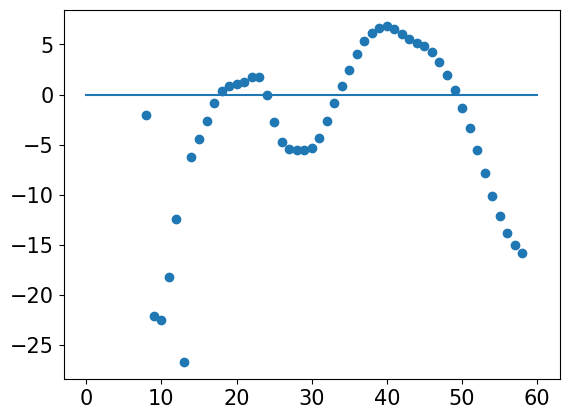

In [20]:
plt.scatter(np.arange(len(stats["rel"]["sum"] / stats["rel"]["count"])), (stats["rel"]["sum"] / stats["rel"]["count"]))
plt.plot([0,60],[0,0])

In [19]:
print("Cleaning up resources...")
try:
    client.close()
    cluster.close()
    print("Dask cluster closed successfully!")
except:
    print("Note: Dask cluster may have already been closed")

gc.collect()
print("Memory cleanup completed!")

Cleaning up resources...


Dask cluster closed successfully!
Memory cleanup completed!
